# OVERVIEW OF DATASET
**Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.**

**To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.**

**The dataset consists about 28000 text data points where each data category belongs to 2 category - Sarcastic or Not Sarcastic**

**We will use two models for making predictions - Word2Vec and GloVe Embeddings. We will then compare their results and see which performs better**
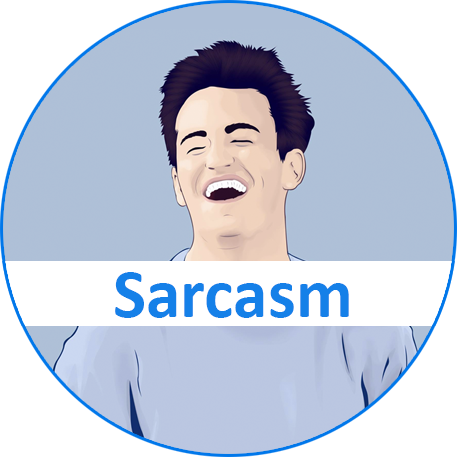

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# LOADING THE NECESSARY LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

# LOADING THE DATASET

In [3]:
df = pd.read_json("./Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# DATA VISUALIZATION AND PREPROCESSING

In [4]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [5]:
del df['article_link'] # Deleting this column as it is of no use

In [6]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

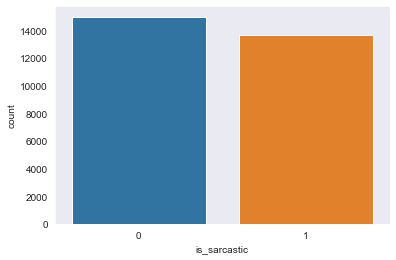

In [7]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**BASIC DATA CLEANING**

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


**WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC (LABEL - 0)**

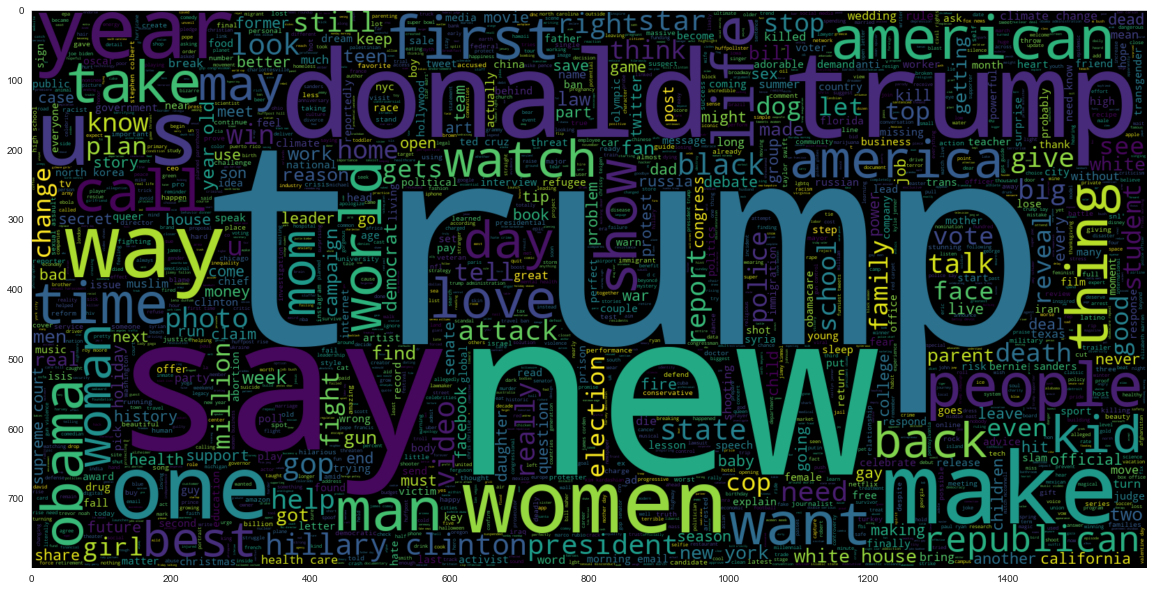

In [10]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR SARCASTIC TEXT (LABEL - 1)**

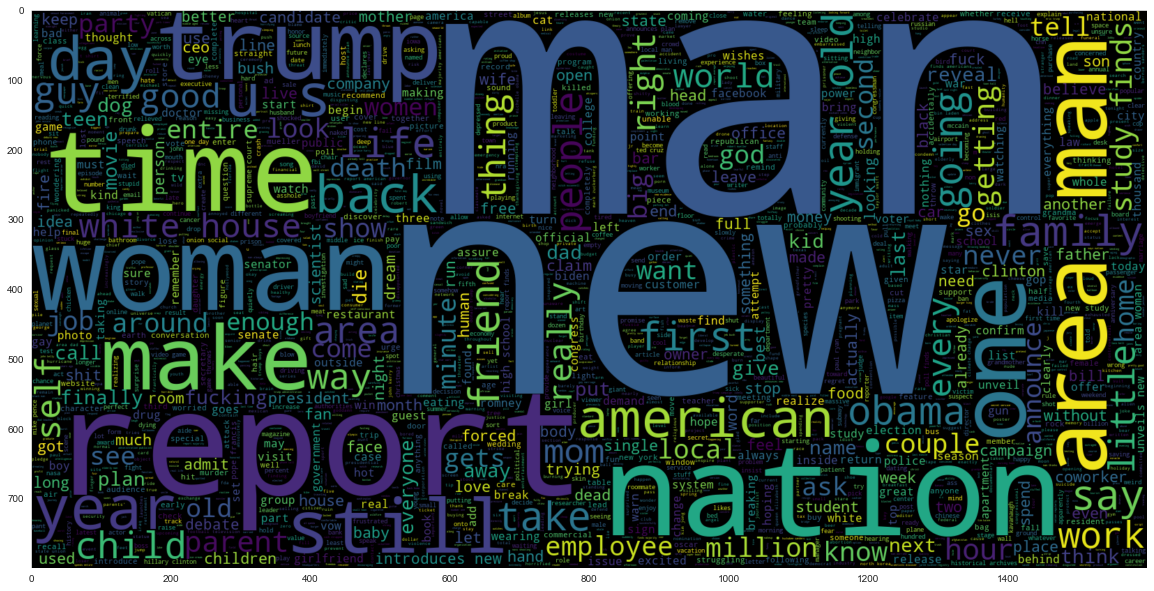

In [11]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

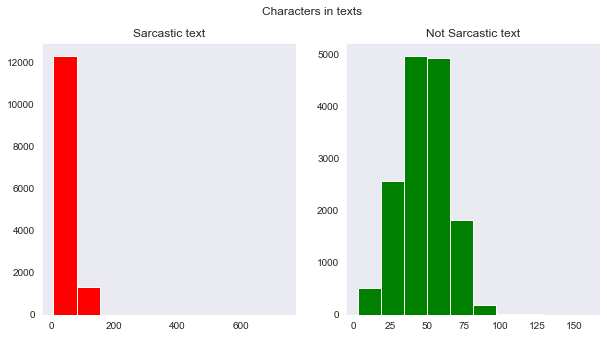

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each text**

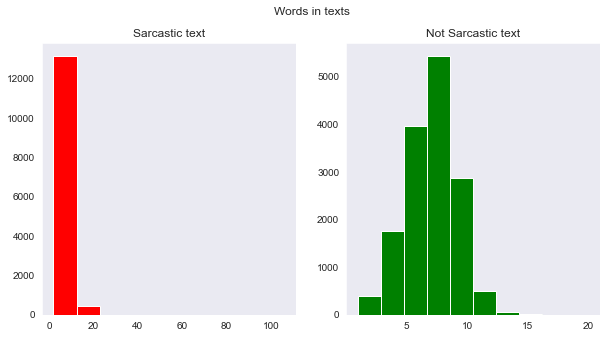

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

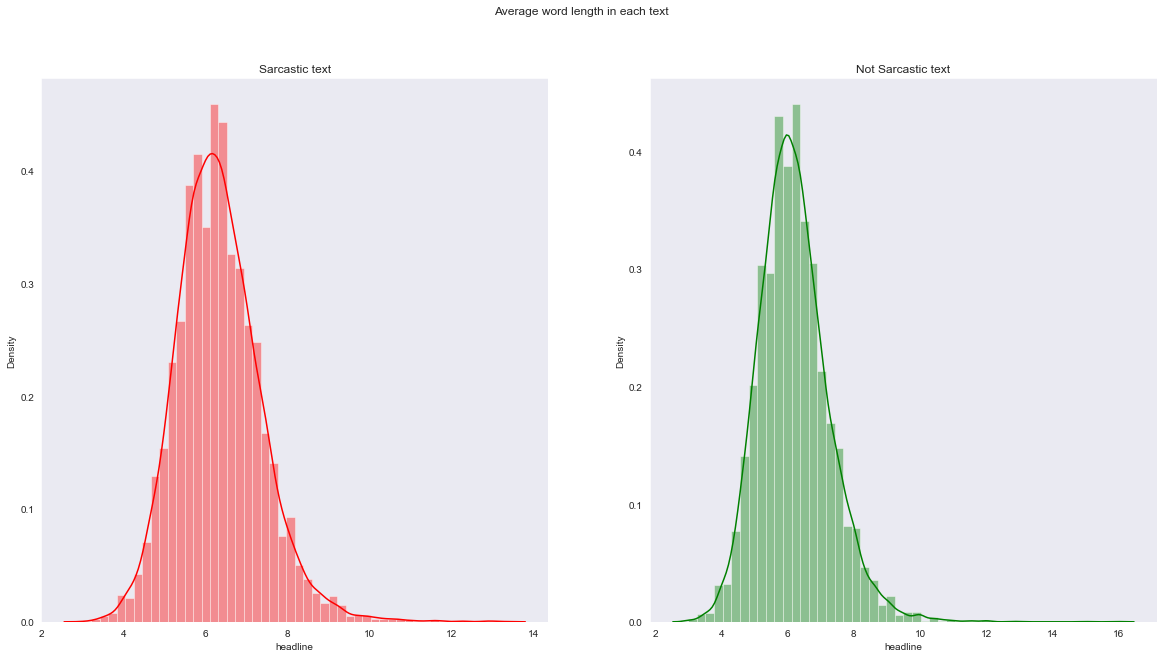

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

# Introduction to Word Embedding and Word2Vec
**Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.
What are word embeddings exactly? Loosely speaking, they are vector representations of a particular word. Having said this, what follows is how do we generate them? More importantly, how do they capture the context?
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.**

# Why do we need them?
**Consider the following similar sentences: Have a good day and Have a great day. They hardly have different meaning. If we construct an exhaustive vocabulary (let’s call it V), it would have V = {Have, a, good, great, day}.
Now, let us create a one-hot encoded vector for each of these words in V. Length of our one-hot encoded vector would be equal to the size of V (=5). We would have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. That particular element would be one. The encodings below would explain this better.
Have = [1,0,0,0,0] ; a=[1,0,0,0,0] ; good=[0,0,1,0,0] ; great=[0,0,0,1,0] ; day=[0,0,0,0,1] (represents transpose)
If we try to visualize these encodings, we can think of a 5 dimensional space, where each word occupies one of the dimensions and has nothing to do with the rest (no projection along the other dimensions). This means ‘good’ and ‘great’ are as different as ‘day’ and ‘have’, which is not true.**
**Our objective is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.**
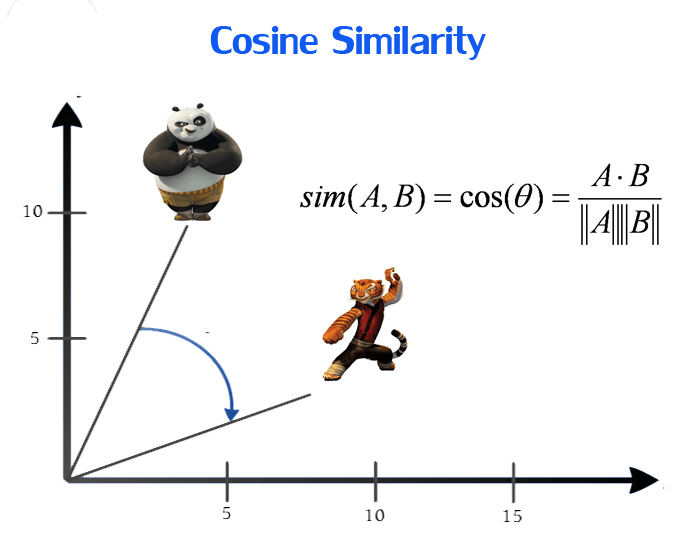
**Here comes the idea of generating distributed representations. Intuitively, we introduce some dependence of one word on the other words. The words in context of this word would get a greater share of this dependence. In one hot encoding representations, all the words are independent of each other, as mentioned earlier.**

**Source Credits : https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa **

**Converting text to format acceptable by gensim**

In [15]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [40]:
print(df.headline.values)

['thirtysomething scientists unveil doomsday clock hair loss'
 'dem rep. totally nails congress falling short gender, racial equality'
 'eat veggies: 9 deliciously different recipes' ...
 'beautiful acceptance speech week came queer korean'
 'mars probe destroyed orbiting spielberg-gates space palace'
 'dad clarifies food stop']


In [16]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [17]:
#vocab size
len(w2v_model.wv.key_to_index)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [44]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [19]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
#     weight_matrix = model.wv.key_to_index.keys()
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [21]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)
# embedding_vectors = w2v_model.wv.get_keras_embedding(train_embeddings=False)

# TRAINING WORD2VEC MODEL

In [22]:
from keras.layers import Embedding
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           7614400   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


In [43]:
print(x)

[[    0     0     0 ...  2336   558   944]
 [    0     0     0 ... 11455  1990  1810]
 [    0     0     0 ... 16794   480  1357]
 ...
 [    0     0     0 ...   957   671  1654]
 [    0     0     0 ...  3001   825  5968]
 [    0     0     0 ...  2970   171    88]]


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [25]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
157/157 [==============================] - 42s 226ms/step - loss: 0.5085 - acc: 0.7420 - val_loss: 0.4150 - val_acc: 0.8137
Epoch 2/3
157/157 [==============================] - 37s 233ms/step - loss: 0.1385 - acc: 0.9500 - val_loss: 0.5439 - val_acc: 0.7970
Epoch 3/3
157/157 [==============================] - 36s 232ms/step - loss: 0.0367 - acc: 0.9878 - val_loss: 0.7506 - val_acc: 0.7888


In [26]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 6s 9ms/step - loss: 0.0122 - acc: 0.9972
Accuracy of the model on Training Data is -  99.7154712677002
269/269 [==============================] - 2s 9ms/step - loss: 0.7506 - acc: 0.7888
Accuracy of the model on Testing Data is -  78.88423204421997


In [34]:
import os.path
if os.path.isfile('models/trained_model.h5') is False:
    model.save('models/trained_model.h5')

In [35]:
from tensorflow.keras.models import load_model
saved_model = load_model('models/trained_model.h5')

In [36]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           7614400   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


# ANALYSIS AFTER TRAINING OF WORD2VEC MODEL 

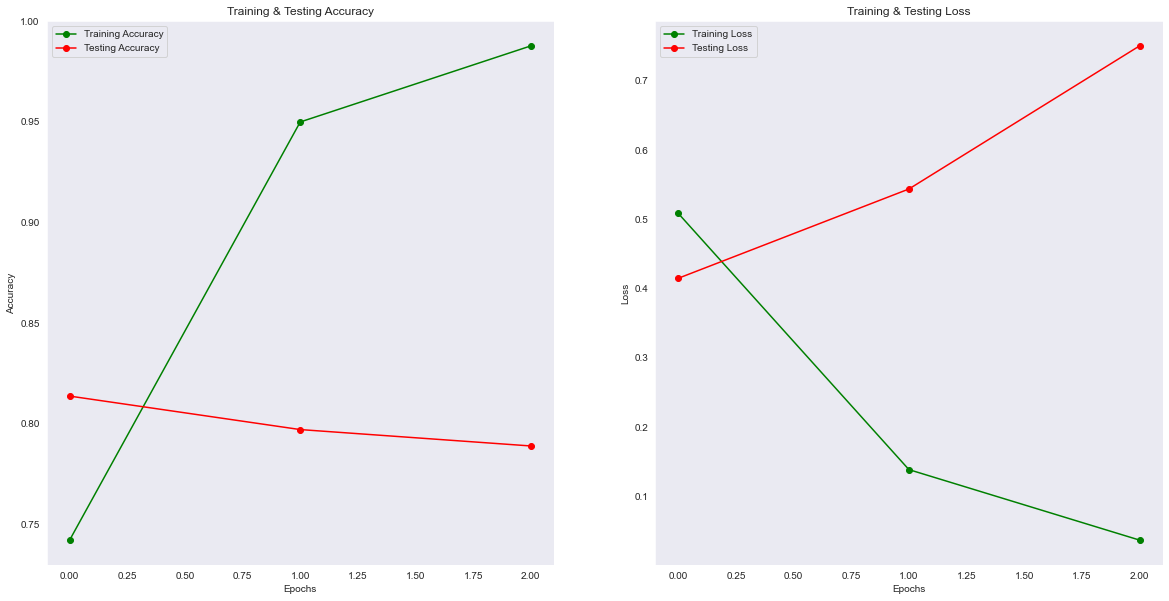

In [30]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**SEEMS LIKE THE MODEL IS OVERFITTING AND NOT PERFORMING WELL ON THE TEST DATA**

In [37]:
print(x_test)

[[    0     0     0 ...    40   395  2349]
 [    0     0     0 ...  5263  2448  3404]
 [    0     0     0 ...  9031  7954   831]
 ...
 [    0     0     0 ...   375  2043 17578]
 [    0     0     0 ...  5263  7529 28756]
 [    0     0     0 ...  1026   158   108]]


In [31]:
# pred = model.predict_classes(x_test)
pred = (model.predict(x_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]])

In [32]:
cm = confusion_matrix(y_test,pred)
cm

array([[3537, 1023],
       [ 790, 3236]], dtype=int64)

<AxesSubplot:>

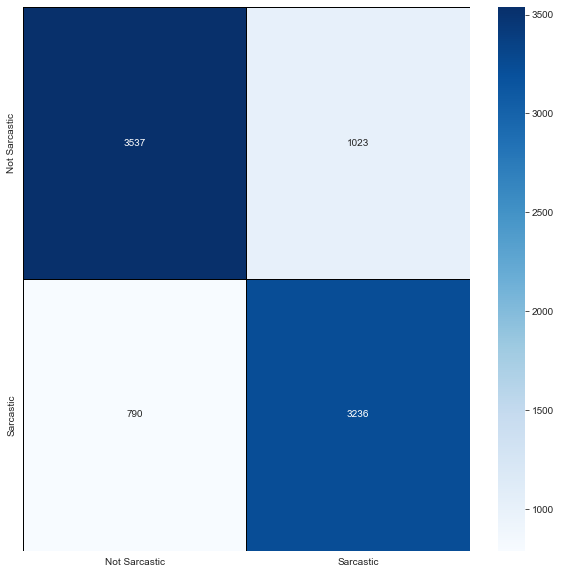

In [33]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])